# Xp model for passes during football matches

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import json
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,SGDClassifier,LogisticRegression,SGDRegressor,LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import shuffle
import xgboost
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_pickle("/content/drive/My Drive/passes_dataset (1).pkl")
data=shuffle(data)

In [ ]:
data

,pass_angle,pass_length,pass_outcome,duration,end_location_x,end_location_y,start_location_x,start_location_y
860,-2.055274,12.882546,Complete,0.722900,66.0,65.1,72.0,76.5
29,-2.812466,30.010832,Complete,2.200200,39.5,66.9,67.9,76.6
822,2.745742,29.046170,Complete,2.072977,34.8,50.4,61.6,39.2
880,-2.784972,16.327278,Complete,2.761291,99.9,74.3,115.2,80.0
481,0.982794,10.816654,Complete,0.986219,50.0,64.0,44.0,55.0
...,...,...,...,...,...,...,...,...
457,-0.095598,7.333485,Complete,0.877200,49.9,48.1,42.6,48.8
651,-2.863293,7.280110,Complete,1.029143,83.0,25.0,90.0,27.0
596,-1.032878,54.845420,Out,3.985331,84.9,0.8,56.8,47.9
850,0.000000,11.000000,Complete,1.440000,65.0,9.0,54.0,9.0


[]

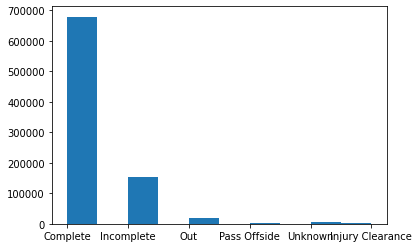

In [ ]:
plt.hist(data["pass_outcome"])
plt.plot()

In [ ]:
len(data[data["pass_outcome"]=="Incomplete"])+len(data[data["pass_outcome"]=="Out"]),len(data[data["pass_outcome"]=="Complete"].iloc[:173101])

(173101, 173101)

In [ ]:
x=np.array(data[data["pass_outcome"]=="Incomplete"])[:,[0,1,3,4,5,6,7]]
x=np.append(x,np.array(data[data["pass_outcome"]=="Out"])[:,[0,1,3,4,5,6,7]],0)
p=np.array(data[data["pass_outcome"]=="Complete"].iloc[:173101])
X=np.append(x,p[:,[0,1,3,4,5,6,7]],0)
y=np.zeros(173101*2)
y[173101:]=1.0

In [ ]:
data.columns

Index(['pass_angle', 'pass_length', 'pass_outcome', 'duration',
       'end_location_x', 'end_location_y', 'start_location_x',
       'start_location_y'],
      dtype='object')

In [ ]:
data.to_pickle("passes_dataset.pkl")

In [ ]:
X.shape,y.shape

((346202, 7), (346202,))

In [ ]:
xx=MinMaxScaler().fit(X)
x=xx.transform(X)

In [ ]:
x,y=shuffle(x,y,random_state=69)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y)

[16:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.29622521202398494


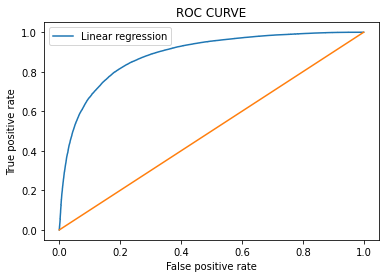

In [ ]:
lr=xgboost.XGBRegressor().fit(x_train,y_train)
print(np.mean(np.abs(lr.predict(x_test)-y_test)))
y_train_pred = lr.predict(x_test)
x,y,z=roc_curve(y_test,y_train_pred)
plt.plot(x,y,label="Linear regression")
plt.plot([0,1],[0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
roc_auc_score(y_test,y_train_pred)

0.8861822595096132

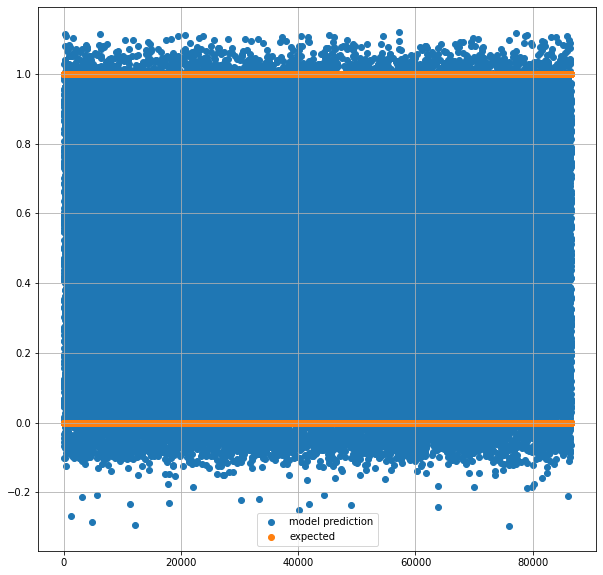

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(y_train_pred)),y_train_pred,label="model prediction")
plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.grid()
plt.show()

In [ ]:
confusion_marix=np.array([[0,0],[0,0]])
for i in range(len(y_test)):
  if y_train_pred[i]<=0.5:
    if y_train[i]==0.0:
      confusion_marix[0][0]+=1
    else:
      confusion_marix[0][1]+=1
  else:
    if y_train[i]==0.0:
      confusion_marix[1][0]+=1
    else:
      confusion_marix[1][1]+=1

In [ ]:
np.mean(np.abs(y_train_pred-y_test))

0.29622521202398494

In [ ]:
confusion_marix

array([[20601, 20784],
       [22551, 22615]])

In [ ]:
from sklearn.neural_network import MLPRegressor,MLPClassifier
regr = MLPClassifier(alpha=0.01,random_state=1, max_iter=500).fit(x_train, y_train)
regr.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.8099609043005269

In [ ]:
y_train_pred=regr.predict_proba(x_test)[:,1]
confusion_marix=np.array([[0,0],[0,0]])
for i in range(len(y_test)):
  if y_train_pred[i]<=0.5:
    if y_train[i]==0.0:
      confusion_marix[0][0]+=1
    else:
      confusion_marix[0][1]+=1
  else:
    if y_train[i]==0.0:
      confusion_marix[1][0]+=1
    else:
      confusion_marix[1][1]+=1

In [ ]:
confusion_marix

array([[19727, 19795],
       [21444, 21396]])

In [ ]:
import tensorflow as tf
from tensorflow import keras
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1028,input_shape=x_train[0].shape),
  keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1208,activation="relu"),
  keras.layers.Dropout(0.2),
  keras.layers.BatchNormalization(),
  #tf.keras.layers.Dense(1208,activation="relu"),
  #keras.layers.Dropout(0.3),
  #keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2,activation="softmax")
])
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005, decay=5e-7),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1028)              8224      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1028)              4112      
_________________________________________________________________
dense_13 (Dense)             (None, 1208)              1243032   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1208)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1208)              4832      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2418      
Total params: 1,262,618
Trainable params: 1,258,146
Non-trainable params: 4,472
________________________________________

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
8115/8115 [==============================] - 142s 17ms/step - loss: 0.5879 - accuracy: 0.7232 - val_loss: 0.4776 - val_accuracy: 0.7809
Epoch 2/10
8115/8115 [==============================] - 141s 17ms/step - loss: 0.4896 - accuracy: 0.7698 - val_loss: 0.4631 - val_accuracy: 0.7882
Epoch 3/10
8115/8115 [==============================] - 141s 17ms/step - loss: 0.4805 - accuracy: 0.7741 - val_loss: 0.4658 - val_accuracy: 0.7873
Epoch 4/10
8115/8115 [==============================] - 140s 17ms/step - loss: 0.4749 - accuracy: 0.7783 - val_loss: 0.4561 - val_accuracy: 0.7897
Epoch 5/10
8115/8115 [==============================] - 142s 18ms/step - loss: 0.4762 - accuracy: 0.7778 - val_loss: 0.4463 - val_accuracy: 0.7965
Epoch 6/10
8115/8115 [==============================] - 150s 18ms/step - loss: 0.4709 - accuracy: 0.7809 - val_loss: 0.4403 - val_accuracy: 0.8005
Epoch 7/10
8115/8115 [==============================] - 148s 18ms/step - loss: 0.4676 - accuracy: 0.7817 - val_loss: 0

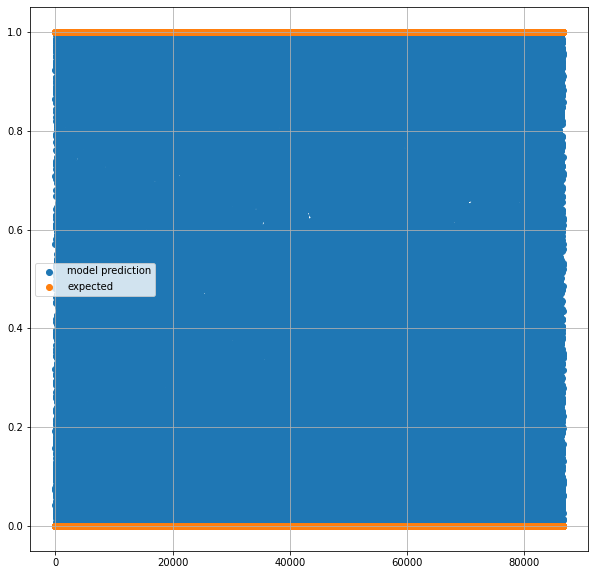

In [ ]:
y_train_pred = model.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(y_train_pred)),y_train_pred[:,1],label="model prediction")
plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save('deep_learning_passes.h5')

In [ ]:
loaded_model = tf.keras.models.load_model("/content/deep_learning_passes.h5")

In [ ]:
loaded_model.predict(x_test[:10])

array([[0.5186367 , 0.4813634 ],
       [0.8081158 , 0.19188423],
       [0.29149628, 0.7085037 ],
       [0.42983505, 0.5701649 ],
       [0.13515998, 0.86484   ],
       [0.07739047, 0.92260957],
       [0.68309057, 0.31690946],
       [0.8418428 , 0.15815724],
       [0.9261231 , 0.07387694],
       [0.92264956, 0.07735042]], dtype=float32)

In [ ]:
model.predict(x_test[:10])

array([[0.5186367 , 0.4813634 ],
       [0.8081158 , 0.19188423],
       [0.29149628, 0.7085037 ],
       [0.42983505, 0.5701649 ],
       [0.13515998, 0.86484   ],
       [0.07739047, 0.92260957],
       [0.68309057, 0.31690946],
       [0.8418428 , 0.15815724],
       [0.9261231 , 0.07387694],
       [0.92264956, 0.07735042]], dtype=float32)

In [ ]:
np.mean(np.abs(model.predict(x_test)[:,1]-y_test))

0.28655698646100397

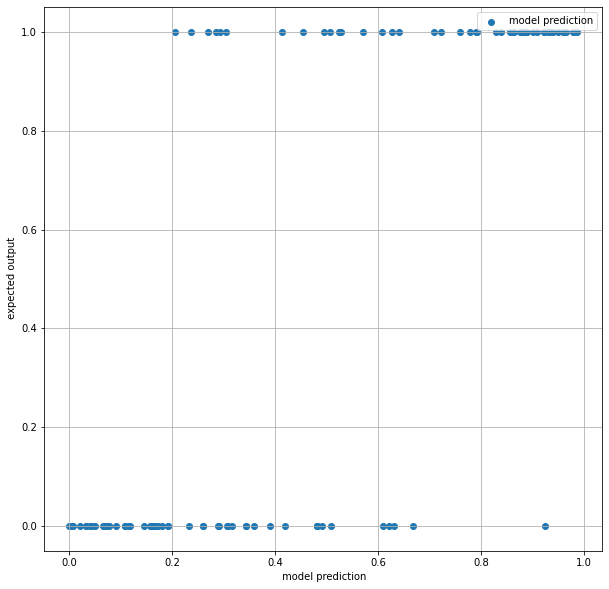

In [ ]:
plt.figure(figsize=(10,10))
x_test1=x_test[:100]
y_train_pred=model.predict(x_test1)[:,1]
plt.scatter(y_train_pred,y_test[:100],label="model prediction")
#plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.ylabel(" expected output")
plt.xlabel(" model prediction")
plt.grid()
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/69216.json

--2021-03-01 17:45:04--  https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/69216.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2973550 (2.8M) [text/plain]
Saving to: ‘69216.json’

69216.json          100%[===================>]   2.83M  --.-KB/s    in 0.1s    

2021-03-01 17:45:04 (23.4 MB/s) - ‘69216.json’ saved [2973550/2973550]



In [ ]:
match=pd.read_json("/content/69216.json")

In [ ]:
match.set_index(["id"],inplace=True)

In [ ]:
match.columns

Index(['index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'duration',
       'tactics', 'related_events', 'player', 'position', 'location', 'pass',
       'carry', 'ball_receipt', 'interception', 'under_pressure',
       'counterpress', 'foul_won', 'off_camera', 'duel', 'out', 'shot',
       'goalkeeper', 'clearance', 'dribble', 'foul_committed', 'ball_recovery',
       '50_50', 'miscontrol', 'block', 'substitution'],
      dtype='object')

In [ ]:
for i in range(1000):
  if str(match.iloc[i]["shot"])!="nan":
    print(i)

165
421
526
670
682


In [ ]:
match

,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,tactics,related_events,player,position,location,pass,carry,ball_receipt,interception,under_pressure,counterpress,foul_won,off_camera,duel,out,shot,goalkeeper,clearance,dribble,foul_committed,ball_recovery,50_50,miscontrol,block,substitution
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87b9074c-7685-416e-b7c1-32468fa9c7d1,1,1,2021-03-01 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,"{'formation': 433, 'lineup': [{'player': {'id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc8a26a1-8017-47c9-bb30-d25f9b9ffd28,2,1,2021-03-01 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 215, 'name': 'Athletic Bilbao'}",0.000000,"{'formation': 4231, 'lineup': [{'player': {'id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f61d2eef-33af-40f0-ac0f-97da900cf799,3,1,2021-03-01 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 215, 'name': 'Athletic Bilbao'}",0.000000,NaN,[cd5ffdc1-b39f-4649-9d0b-bdb09a952e42],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cd5ffdc1-b39f-4649-9d0b-bdb09a952e42,4,1,2021-03-01 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,NaN,[f61d2eef-33af-40f0-ac0f-97da900cf799],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6edb25f9-206f-47ca-a8ea-0900c63f1fdf,5,1,2021-03-01 00:00:00.964,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 217, 'name': 'Barcelona'}","{'id': 9, 'name': 'From Kick Off'}","{'id': 217, 'name': 'Barcelona'}",1.357694,NaN,[d05954af-8e8d-48a9-a685-6261f7830faf],"{'id': 5216, 'name': 'Andrés Iniesta Luján'}","{'id': 15, 'name': 'Left Center Midfield'}","[60.0, 40.0]","{'recipient': {'id': 20131, 'name': 'Xavier He...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4aa90710-c9f1-4dac-8a89-b713b35b2547,3407,2,2021-03-01 00:49:04.678,94,4,"{'id': 43, 'name': 'Carry'}",192,"{'id': 217, 'name': 'Barcelona'}","{'id': 3, 'name': 'From Free Kick'}","{'id': 217, 'name': 'Barcelona'}",1.027519,NaN,"[2a8a9a34-c4c0-421c-8b1e-615246a38d6a, c3ab798...","{'id': 20131, 'name': 'Xavier Hernández Creus'}","{'id': 13, 'name': 'Right Center Midfield'}","[76.3, 30.9]",NaN,"{'end_location': [77.2, 30.9]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2a8a9a34-c4c0-421c-8b1e-615246a38d6a,3408,2,2021-03-01 00:49:05.706,94,5,"{'id': 30, 'name': 'Pass'}",192,"{'id': 217, 'name': 'Barcelona'}","{'id': 3, 'name': 'From Free Kick'}","{'id': 217, 'name': 'Barcelona'}",2.866484,NaN,[a95c3ca5-6b68-4fc5-ba55-4d728a08a953],"{'id': 20131, 'name': 'Xavier Hernández Creus'}","{'id': 13, 'name': 'Right Center Midfield'}","[77.2, 30.9]","{'recipient': {'id': 6758, 'name': 'Víctor Sán...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a95c3ca5-6b68-4fc5-ba55-4d728a08a953,3409,2,2021-03-01 00:49:08.572,94,8,"{'id': 42, 'name': 'Ball Receipt*'}",192,"{'id': 217, 'name': 'Barcelona'}","{'id': 3, 'name': 'From Free Kick'}","{'id': 217, 'name': 'Barcelona'}",NaN,NaN,[2a8a9a34-c4c0-421c-8b1e-615246a38d6a],"{'id': 6758, 'name': 'Víctor Sánchez Mata'}","{'id': 2, 'name': 'Right Back'}","[79.7, 75.1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
match.iloc[0]["tactics"]

{'formation': 433,
 'lineup': [{'jersey_number': 1,
   'player': {'id': 20176, 'name': 'Víctor Valdés Arribas'},
   'position': {'id': 1, 'name': 'Goalkeeper'}},
  {'jersey_number': 5,
   'player': {'id': 20125, 'name': 'Carles Puyol i Saforcada'},
   'position': {'id': 2, 'name': 'Right Back'}},
  {'jersey_number': 3,
   'player': {'id': 5213, 'name': 'Gerard Piqué Bernabéu'},
   'position': {'id': 3, 'name': 'Right Center Back'}},
  {'jersey_number': 4,
   'player': {'id': 5558, 'name': 'Rafael Márquez Álvarez'},
   'position': {'id': 5, 'name': 'Left Center Back'}},
  {'jersey_number': 16,
   'player': {'id': 25854, 'name': 'Sylvio Mendes Campos Junior'},
   'position': {'id': 6, 'name': 'Left Back'}},
  {'jersey_number': 16,
   'player': {'id': 5203, 'name': 'Sergio Busquets i Burgos'},
   'position': {'id': 10, 'name': 'Center Defensive Midfield'}},
  {'jersey_number': 6,
   'player': {'id': 20131, 'name': 'Xavier Hernández Creus'},
   'position': {'id': 13, 'name': 'Right Center 

Index(['pass_angle', 'pass_length', 'pass_outcome', 'duration',
       'end_location_x', 'end_location_y', 'start_location_x',
       'start_location_y'],
      dtype='object')

In [ ]:
j=0
names=[]
val1=[]
val=[]
for i in match.iloc[0:3000]["pass"]:
  if ((str(i)!="nan") and (match.iloc[j]["possession_team"]["name"]=="Barcelona")):
    v=[[i["angle"],i["length"],match.iloc[j]["duration"],i["end_location"][0],i["end_location"][1],match.iloc[j]["location"][0],match.iloc[j]["location"][1]]]
    #print([i["length"],i["end_location"][0],i["end_location"][1],match.iloc[j]["duration"],i["angle"]],i["recipient"]["name"])
    if "outcome" not in i:
      #print(model.predict(xx.transform(v)),i["outcome"]["name"],match.iloc[j]["player"]["name"])
      val.append(model.predict(xx.transform(v))[0][0])
      names.append(match.iloc[j]["player"]["name"])
    else:
      val1.append(model.predict(xx.transform(v))[0][0])
  j+=1

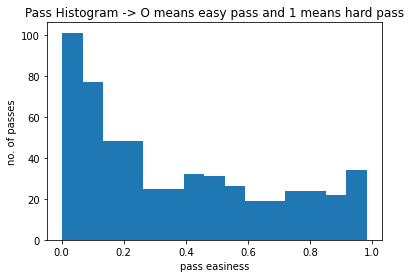

In [ ]:
plt.hist(val+val1,bins=15)
plt.xlabel("pass easiness")
plt.ylabel("no. of passes")
plt.title("Pass Histogram -> O means easy pass and 1 means hard pass")
plt.show()
# 0 means easy pass and 1 means hard pass.

In [ ]:
dic=dict()
count=dict()
for i in set(names):
  dic[i]=0
  count[i]=0
for j in range(len(val)):
  dic[names[j]]+=val[j]
  count[names[j]]+=1

In [ ]:
for i in dic.keys():
  dic[i]=dic[i]/count[i]

In [ ]:
len(val1)

95

In [ ]:
dic

{'Andoni Iraola Sagarna': 0.31697091460227966,
 'Andrés Iniesta Luján': 0.29964089862352133,
 'Carles Puyol i Saforcada': 0.17975456837746429,
 'Carlos Gurpegi Nausia': 0.11313187144696712,
 'Fernando Amorebieta Mardaras': 0.4745787273471554,
 'Fernando Llorente Torres': 0.14907629787921906,
 'Gerard Piqué Bernabéu': 0.2782483273820782,
 'Gorka Iraizoz Moreno': 0.7204262018203735,
 'Javier Martínez Aginaga': 0.1243538036942482,
 'Koikili Lertxundi Del Campo': 0.16584303975105286,
 'Lionel Andrés Messi Cuccittini': 0.32239898881225876,
 'Pablo Orbaiz Lesaka': 0.2882261872291565,
 'Rafael Márquez Álvarez': 0.3457334717310479,
 'Samuel Eto"o Fils': 0.36377217682699364,
 'Sergio Busquets i Burgos': 0.22915463713463397,
 'Sylvio Mendes Campos Junior': 0.2929763361409476,
 'Thierry Henry': 0.38087348888317746,
 'Víctor Valdés Arribas': 0.30544380117207764,
 'Xavier Hernández Creus': 0.27974427426094883}

In [ ]:
len(dic)

19

In [ ]:
# we can see above and find the GOAT is making lots of difficult passing.

if using this model in future use the features in the order of 

['pass_angle', 'pass_length','duration', 'end_location_x', 'end_location_y', 'start_location_x', 'start_location_y']